In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
import time
import torch.nn as nn

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [35]:
from configs import configs
from dataset_import import load_dataset
from simple_model import SimpleModel

config = configs["phishing"]

n_epoch = config.n_epoch
time_lim = config.time_lim
batch_size = config.batch_size
repeat_times = config.repeat_times

bias = config.bias

l2 = config.l2
lr = config.lr
lr_lambda = config.lr_lambda

optimizer_class = config.optimizer_class
criterion = config.criterion
processing = config.processing

dataset = load_dataset(config.dataset_name)
clustered_data, full_labels = dataset.tensors
labeled_data = processing(dataset)
N, DIM = clustered_data.shape
N, DIM

(11055, 68)

In [7]:
from cluster_tools import kmeans_elbow_aux, ClusterSampler, logistic_label_01_process

Samplers

In [8]:
# probably utils function
from utils import dimension_reduction
from simple_model import least_squares_crit

compressed_data = dimension_reduction(clustered_data, alg="pca")

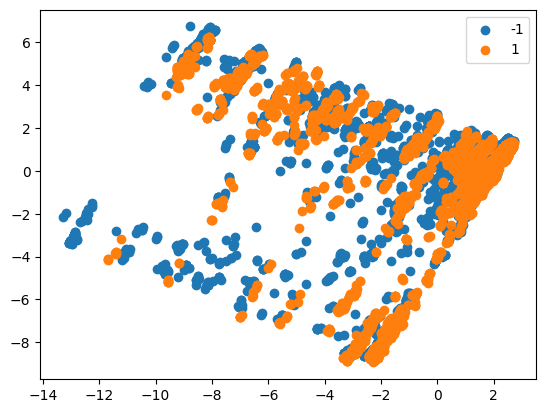

In [9]:
if criterion != least_squares_crit:
    compressed_labeled = dimension_reduction(labeled_data, alg="pca")
    mask_0 = (full_labels == -1)
    mask_1 = (full_labels == 1)
    plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], label="-1")
    plt.scatter(compressed_data[mask_1,0], compressed_data[mask_1,1], label="1")
    plt.legend()
    plt.show()
else:
    plt.scatter(compressed_data[:,0], compressed_data[:,1])
    plt.show()

In [10]:
def get_grad(batch, labels, model, criterion=criterion):
    ret = np.zeros_like(batch)
    for i, (elem, lab) in enumerate(zip(batch, labels)):
        res = model(elem)
        l = criterion(res, lab)
        model.zero_grad()
        l.backward()
        ret[i] = (next(model.parameters()).grad.data.detach().numpy().squeeze())
    return ret

In [11]:
from torch import Tensor

def display_grads(dataset:TensorDataset, model, cluster_sampler, alg="pca", title=""):
    n = len(dataset)
    
    dataset_torch, labels = dataset.tensors
    gradients = np.zeros_like(dataset_torch)
    lims = [0]
    for i in range(cluster_sampler.cluster_count):
        selected = dataset_torch[cluster_sampler.clusters[i]]
        selected_labels = labels[cluster_sampler.clusters[i]]
        grad_selected = get_grad(selected, selected_labels, model)
        # print(grad_selected)
        lims.append(lims[-1] + len(cluster_sampler.clusters[i]))
        gradients[lims[-2]:lims[-1], :] = grad_selected
    
    reduced = dimension_reduction(gradients, alg=alg)

    for i in range(cluster_sampler.cluster_count):
        plt.scatter(reduced[lims[i]:lims[i+1],0], 
                    reduced[lims[i]:lims[i+1],1], 
                    alpha=0.5,
                    label="cluster size {}".format(len(cluster_sampler.clusters[i])))
    plt.legend()
    plt.title(title)
    plt.show()

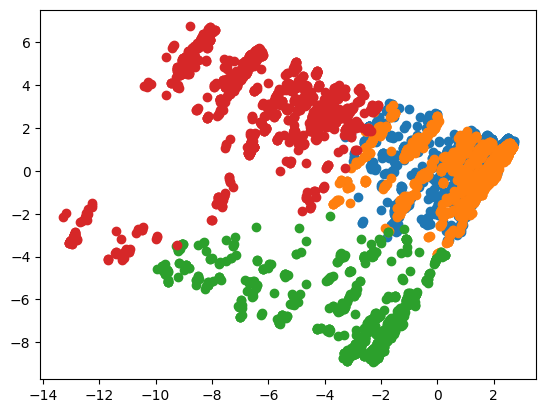

In [12]:
from cluster_tools import get_clusters

kmeans_clusters = get_clusters(dataset)#, logistic_label_01_process)

cluster_sampler = ClusterSampler(N, batch_size, kmeans_clusters)
for i in range(cluster_sampler.cluster_count):
    selected = compressed_data[cluster_sampler.clusters[i]]
    try:
        plt.scatter(selected[:,0], selected[:,1])
    except:
        print(selected)
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

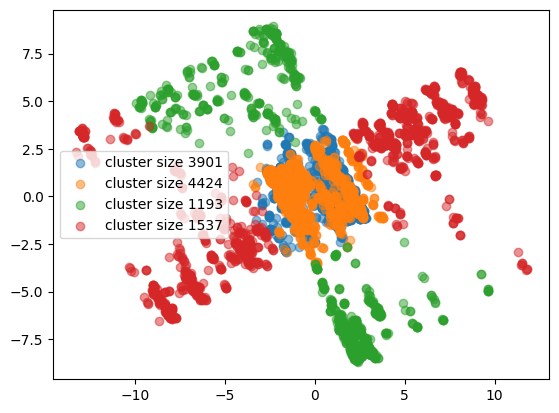

In [13]:
display_grads(dataset, SimpleModel(DIM, bias), cluster_sampler)

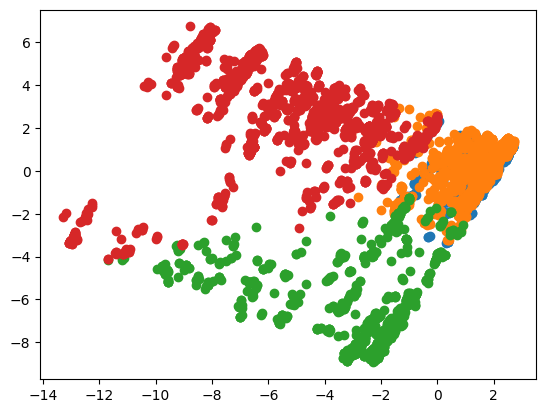

In [14]:
from cluster_tools import kmeans_cos_elbow

cos_clusters = get_clusters(dataset, clustering_method=kmeans_cos_elbow)
cosine_cluster_sampler = ClusterSampler(N, batch_size, cos_clusters)
for i in range(cosine_cluster_sampler.cluster_count):
    selected = compressed_data[cosine_cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

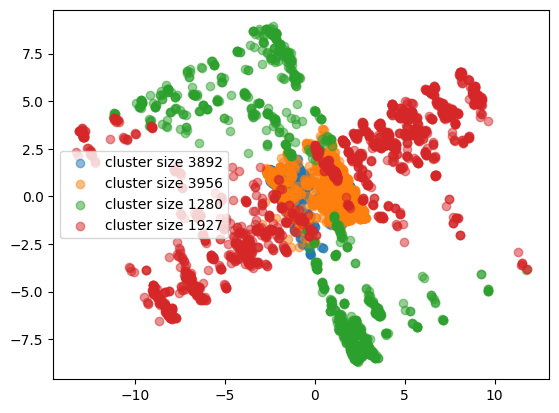

In [15]:
display_grads(dataset, SimpleModel(DIM, bias), cosine_cluster_sampler)

Solvers

In [16]:
# for regression only


if criterion == least_squares_crit:
    A = clustered_data
    b = full_labels

    opt_weights = torch.from_numpy(
        np.linalg.solve(A.T@A + l2*np.eye(DIM,dtype=np.float32), 
                        A.T@b))
    print(opt_weights)
    opt_val = (least_squares_crit(A@opt_weights, b) \
        + l2/2*(opt_weights**2).sum()).item()
    print(opt_val)

In [17]:
# finding an exact solution

from tqdm import tqdm
from solvers import get_regularized_loss
from simple_model import SimpleModel

model = SimpleModel(DIM, bias)

def train_model_until(model, 
                      data, 
                      labels, 
                      criterion, 
                      err, 
                      lr=lr, 
                      opt_val=None, 
                      display_interval=1000,
                      hard_limit=100000):
    curr_epoch = 0
    regularized_ls = []

    while 1:
        reg_loss = get_regularized_loss(model, 
                                        data, 
                                        labels, 
                                        criterion,
                                        l2)
        model.zero_grad()
        reg_loss.backward()
        for p in model.parameters():
            p.data.sub_(lr*(p.grad.data))
        regularized_ls.append(reg_loss.item())
        curr_epoch += 1
        if curr_epoch % display_interval == 0:
            print(curr_epoch, reg_loss.item())
        if curr_epoch > 1:
            if opt_val is None and regularized_ls[-2] - regularized_ls[-1] < err:
                break
            if opt_val is not None and regularized_ls[-1] - opt_val < err:
                break
        if curr_epoch >= hard_limit:
            break
    return curr_epoch, regularized_ls

if criterion == least_squares_crit:
    with torch.no_grad():
        model.layer.weight.copy_(opt_weights)

else:   
    curr_epoch, regularized_ls = train_model_until(
        model, 
        clustered_data, 
        full_labels,
        criterion,
        1e-11)
    opt_val = min(regularized_ls)
    print(curr_epoch, opt_val)

1000 0.14272117614746094
2000 0.14241266250610352
3000 0.1423519402742386
3089 0.14234896004199982


In [18]:
output = model(clustered_data)
model.zero_grad()
loss = criterion(output, full_labels)
print(loss)
loss.backward()
for p in model.parameters():
    print(p.grad.data + l2*p.data)
    print(p.data)

tensor(0.1418, grad_fn=<MeanBackward0>)
tensor([[ 5.7963e-06, -4.5445e-07,  3.1510e-06, -9.8499e-07, -4.3823e-06,
          2.5368e-04,  1.7942e-06,  1.9229e-06,  1.3103e-07,  3.2485e-05,
         -1.1758e-05, -1.2398e-06,  2.2321e-08,  4.9711e-05, -2.1045e-06,
          2.3488e-06, -3.3804e-06, -8.3516e-07, -2.5861e-06,  1.5448e-06,
         -8.9339e-07, -2.5876e-05,  4.9997e-06, -1.4998e-06,  5.2470e-06,
         -3.3855e-06, -2.5034e-07, -1.7239e-06, -2.5114e-06,  3.6530e-07,
         -5.7963e-06,  4.3823e-06,  1.8636e-06, -2.9813e-06, -2.3608e-05,
          5.6866e-06,  3.3804e-06,  8.3516e-07,  4.8452e-06, -3.6530e-07,
         -1.2155e-06,  1.4998e-06, -1.2792e-06,  2.7958e-06, -1.3103e-07,
         -2.2321e-08, -3.7272e-06, -7.5596e-07, -3.1510e-06, -3.5466e-06,
          1.2398e-06, -1.5448e-06,  2.5876e-05, -5.2470e-06,  2.5034e-07,
          1.8733e-06, -2.5368e-04, -1.2980e-08,  7.7451e-07,  9.8499e-07,
          1.1758e-05,  8.9339e-07, -4.9997e-06, -2.6339e-05,  2.5861e-06

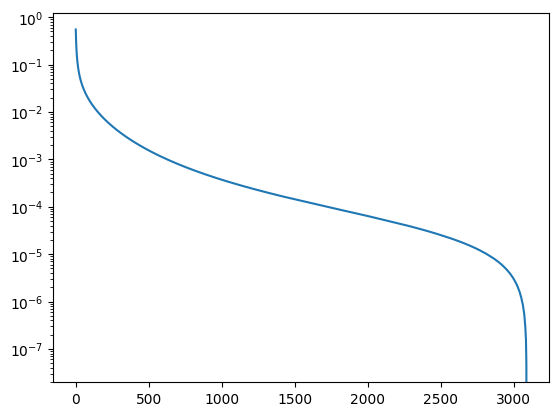

In [19]:
if criterion != least_squares_crit:
    plt.plot(np.arange(1, len(regularized_ls)+1), np.array(regularized_ls)-opt_val)
    plt.yscale("log")
    # plt.loglog()
    plt.show()

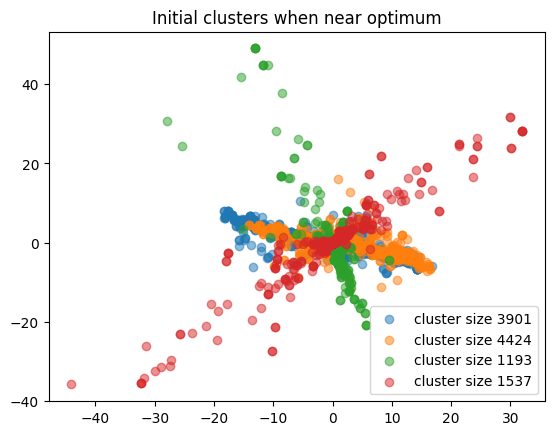

In [20]:
display_grads(dataset, model, cluster_sampler, title="Initial clusters when near optimum")

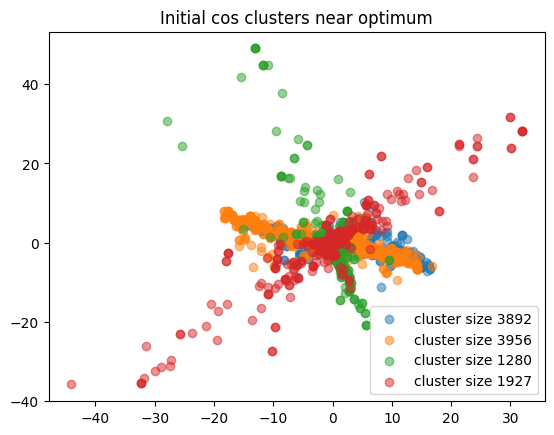

In [21]:
display_grads(dataset, model, cosine_cluster_sampler, title="Initial cos clusters near optimum")

Getting gradients closer to the objective, testing out if reclustering could in theory work

In [22]:
from cluster_tools import kmeans_pp_elbow

close_model = SimpleModel(DIM, bias)
if criterion == least_squares_crit:
    train_model_until(
        close_model, 
        clustered_data,
        full_labels,
        criterion,
        1e-2,
        lr=1e-1,
        opt_val=opt_val,
    )
else:
    train_model_until(
        close_model, 
        clustered_data, 
        full_labels,
        criterion,
        1e-4
    )

In [23]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

# close_cluster_labels = kmeans_pp_elbow(get_grad(clustered_data, full_labels, close_model))
close_cluster_labels = KMeans(n_clusters=4).fit(preprocessing.normalize(get_grad(clustered_data, full_labels, close_model))).labels_
new_cluster_sampler = ClusterSampler(N, batch_size, close_cluster_labels)

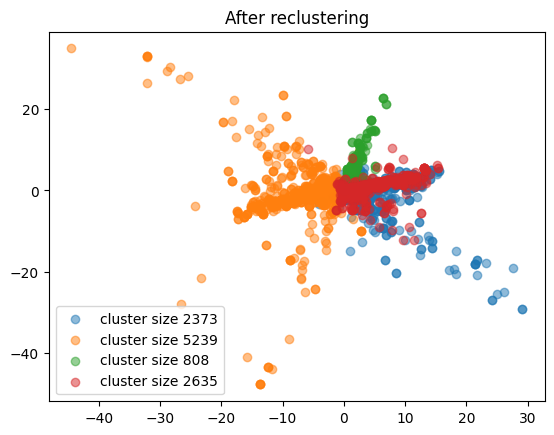

In [24]:
display_grads(dataset, close_model, new_cluster_sampler, title="After reclustering")

In [25]:
# close_cos_cluster_labels = kmeans_pp_elbow(get_grad(clustered_data, full_labels, close_model), "cosine")
# close_cos_cluster_labels = KMeans(n_clusters=4).fit(preprocessing.normalize(get_grad(clustered_data, full_labels, close_model))).labels_
# new_cluster_sampler = ClusterSampler(N, batch_size, close_cluster_labels)

# cos_recluster_sampler = ClusterSampler(N, batch_size, close_cos_cluster_labels)
# display_grads(dataset, close_model, cos_recluster_sampler, title="cos recluster")

In [26]:
from solvers import solve_problem, svrg, COVER, clusterSVRG

In [27]:
from utils import clone_model

In [28]:
base_model = SimpleModel(DIM, bias)

In [30]:
cluster_dataloader = DataLoader(dataset, batch_size, sampler=cluster_sampler)
cosine_dataloader = DataLoader(dataset, batch_size, sampler=cosine_cluster_sampler)

iid_sampler = RandomSampler(dataset, replacement=True)
iid_dataloader = DataLoader(dataset, batch_size, sampler=iid_sampler)

new_cluster_dataloader = DataLoader(dataset, batch_size, sampler=new_cluster_sampler)

Clusters from linkage clustering

In [ ]:
from cluster_tools import display_clusters, approx_nearest_clustering
from cluster_tools import alt_elbow

close_gradients = get_grad(clustered_data, full_labels, close_model)

alt_cluster_labels = alt_elbow(labeled_data.detach().numpy())
# alt_cluster_labels = approx_nearest_clustering(close_gradients)
alt_clusters = [[] for _ in range(max(alt_cluster_labels)+1)]
for i, j in enumerate(alt_cluster_labels):
    alt_clusters[j].append(i)

# display_clusters(close_gradients, alt_cluster_labels, max(alt_cluster_labels)+1)

print("nb of clusters:", len(alt_clusters))
for c in alt_clusters:
    print(len(c)/N)

In [ ]:
from solvers import alt_solve_problem

# get number of thing per batch
v = np.zeros(len(alt_clusters))
for i in range(len(alt_clusters)):
    grads = np.mean(close_gradients[alt_clusters[i]], axis=0)
    v[i] = np.mean(np.sum((close_gradients[alt_clusters[i]] - grads)**2, axis=1))
v = torch.from_numpy(v)

_, alt_sol, _ = alt_solve_problem(base_model, 
                                  criterion,
                                  optimizer_class=torch.optim.SGD,
                                  datasource=dataset,
                                  cluster_labels=alt_cluster_labels,
                                  v_i=v,
                                  batch_size=batch_size,
                                  n_epoch=n_epoch,
                                  lr=lr,
                                  l2=l2)

Both for comparison and for checking if the learning rate works

In [31]:
_, sgd_sol, _ = solve_problem(
    clone_model(base_model, DIM, bias), 
    criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, batch_size, shuffle=True),
    n_epoch=n_epoch,
    lr=lr,
    lr_lambda=lr_lambda,
    l2=l2
)

100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


In [32]:
from solvers import full_batch_corresp

_, regular_gd_sol, _ = full_batch_corresp(
    clone_model(base_model, DIM, bias),
    criterion,
    torch.optim.SGD,
    dataset,
    batch_size,
    n_epoch=n_epoch, 
    lr=lr,
    lr_lambda=lr_lambda,
    l2=l2
)

100%|██████████| 17300/17300 [00:03<00:00, 4758.93it/s]


In [33]:
opt_val = min(opt_val, min(sgd_sol))
opt_val = min(opt_val, min(regular_gd_sol))

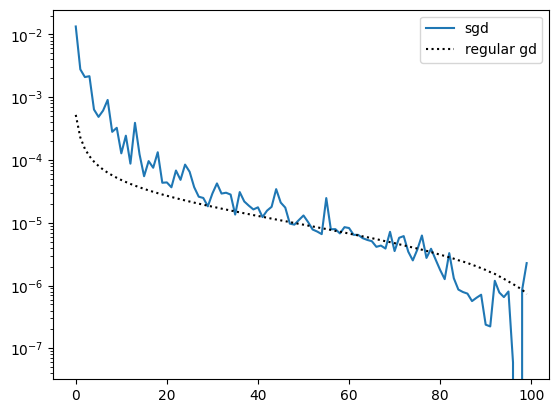

In [34]:
# plt.plot(alt_sol - opt_val, label="alt")
plt.plot(sgd_sol - opt_val, label="sgd")
plt.plot(regular_gd_sol - opt_val, linestyle='dotted', color="black", label="regular gd")

# plt.loglog()
plt.yscale("log")
plt.legend()
plt.show()

In [36]:
def repeat_exec(dataloader,
                base_model=base_model,
                model_args=(DIM, bias),
                criterion=criterion,
                optimizer_class=optimizer_class,
                n_epoch=n_epoch,
                time_lim=time_lim,
                verbose=False,
                repeat_times=repeat_times,
                lr=lr,
                lr_lambda=lr_lambda,
                l2=l2):
    timestamps, sols = [], []
    for i in range(repeat_times):
        sgd_time, sgd_sol, _ = solve_problem(
            clone_model(base_model, *model_args), 
            criterion,
            optimizer_class,
            dataloader,
            n_epoch,
            time_lim,
            verbose,
            lr,
            lr_lambda,
            l2)
        timestamps.append(sgd_time)
        sols.append(sgd_sol)
    return timestamps, sols

In [37]:
sgd_times, sgd_sols = repeat_exec(DataLoader(dataset, batch_size, shuffle=True))

100%|██████████| 100/100 [00:11<00:00,  9.07it/s]


In [38]:
sgd_iid_times, sgd_sols_iid = repeat_exec(iid_dataloader)

100%|██████████| 100/100 [00:10<00:00,  9.49it/s]


In [39]:
sgd_cluster_times, sgd_sols_cluster = repeat_exec(dataloader=cluster_dataloader)

100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


In [40]:
sgd_cosine_times, sgd_sols_cosine = repeat_exec(cosine_dataloader)

100%|██████████| 100/100 [00:13<00:00,  7.43it/s]


In [41]:
# from solvers import weighted_solver
# sgd_alt_cluster_t, sgd_alt_cluster, _ = weighted_solver(
#     clone_model(base_model, clustered_data), 
#     regress_criterion,
#     torch.optim.SGD,
#     dataset,
#     n_iter=None,
#     time_lim=TIME_LIM,
#     verbose=True
# )

In [42]:
# folder = "./saves/"
# bis = "(3)"
# ext = "b" + str(batch_size) + bis + ".txt"

In [43]:
# execution_res_names = ["sgd_sols_iid", "sgd_sols_cluster", "sgd_sols_cosine", "sgd_sols"]
# file_names = ["sgd_iid_", "sgd_clustered_", "cosine_", ""]

In [44]:
# for ref, name in zip(execution_res_names, file_names):
#     exec(ref + " = np.loadtxt(folder + config.dataset_name + name + ext)")

In [45]:
# for ref, name in zip(execution_res_names, file_names):
#     exec("np.savetxt('" + folder + exp_type + name + ext + "', np.array(" + ref + "))")

In [46]:
for losses in [sgd_sols_iid, sgd_sols_cluster, sgd_sols_cosine, sgd_sols]:
    for l in losses:
        opt_val = min(opt_val, min(l))
opt_val

0.14231576025485992

In [47]:
# cluster1 = new_cluster_sampler.clusters[0]
# restricted_data = clustered_data[cluster1]
# restricted_labels = full_labels[cluster1]
# wrong_model = SimpleModel(restricted_data)

# regularized_ls_new = []

# for i in tqdm(range(20000)):
#     reg_loss = get_regularized_loss(wrong_model, 
#                                     restricted_data, 
#                                     restricted_labels, 
#                                     criterion,
#                                     l2)
#     wrong_model.zero_grad()
#     reg_loss.backward()
#     for p in wrong_model.parameters():
#         p.data.sub_(lr*(p.grad.data))
#     regularized_ls_new.append(reg_loss.item())

# plt.plot(np.array(regularized_ls_new) - min(regularized_ls_new))
# plt.loglog()

# opt_wrong = get_regularized_loss(wrong_model, 
#                                     clustered_data, 
#                                     full_labels, 
#                                     criterion,
#                                     l2).item()
# opt_wrong

In [48]:
init_loss = get_regularized_loss(SimpleModel(DIM, bias),
                                 clustered_data,
                                 full_labels,
                                 criterion,
                                 l2).item()
init_loss

0.6931473016738892

In [49]:
def plot_mult_iter(losses, opt_val, color, label, init_loss=init_loss):
    ls = np.array(losses)
    # because they all start at the init_loss
    # also the xscale on log removes the element 0
    ls = np.insert(ls, 0, init_loss, axis=1) 
    # for l in losses:
        # plt.plot(l-opt_val, alpha=0.3, color=color)
    m = np.mean(ls, axis=0)
    std = np.std(ls, axis=0)
    l = len(m)
    plt.plot(np.arange(1, l+1), m-opt_val, color=color, label=label, alpha=0.9)
    # plt.fill_between(np.arange(l), m-opt_val-std, m-opt_val+std, alpha=0.3)

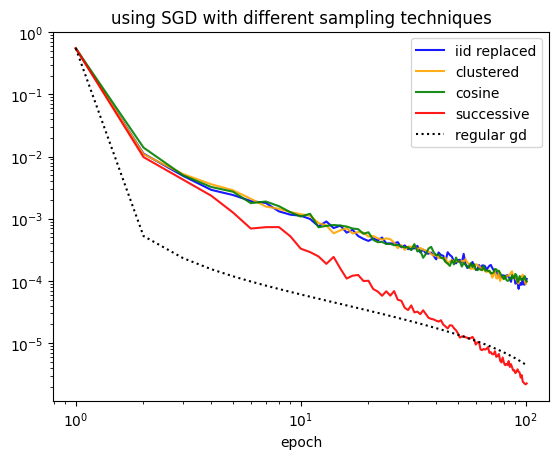

In [50]:
plot_mult_iter(sgd_sols_iid, opt_val, color="blue", label="iid replaced")
plot_mult_iter(sgd_sols_cluster, opt_val, color="orange", label="clustered")
plot_mult_iter(sgd_sols_cosine, opt_val, color="green", label="cosine")
plot_mult_iter(sgd_sols, opt_val, color="red", label="successive")

l1 = np.insert(regular_gd_sol, 0, init_loss)
plt.plot(np.arange(1, n_epoch+2), 
         l1 - opt_val, 
         linestyle='dotted', 
         color="black", 
         label="regular gd")


plt.legend()
# plt.yscale("log")
plt.loglog()
plt.xlabel("epoch")
plt.title("using SGD with different sampling techniques")
plt.show()

What happens after reclustering?

In [51]:
init_loss_bis = get_regularized_loss(
    close_model,
    clustered_data,
    full_labels,
    criterion,
    l2).item()
init_loss_bis

0.1534506231546402

In [77]:
lr_one_t_bis = lambda epoch: 5 / (epoch+100)

In [85]:
def repeat_recluster(dataloader):
    return repeat_exec(
        dataloader, 
        base_model=close_model, 
        lr_lambda=lr_one_t_bis,
        n_epoch=50,
        # lr=1e-6,
        repeat_times=10
    )

In [86]:
sgd_bis_times, sgd_bis = repeat_recluster(DataLoader(dataset, batch_size, shuffle=True))
sgd_iid_bis_times, sgd_iid_bis = repeat_recluster(iid_dataloader)
sgd_rec_times, sgd_rec_bis = repeat_recluster(new_cluster_dataloader)

100%|██████████| 50/50 [00:01<00:00, 43.86it/s]


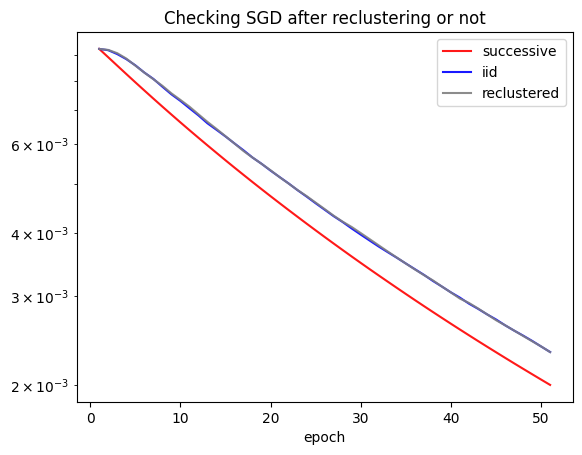

In [87]:
plot_mult_iter(sgd_bis, opt_val, color="red", label="successive", init_loss=init_loss_bis)
plot_mult_iter(sgd_iid_bis, opt_val, color="blue", label="iid", init_loss=init_loss_bis)
plot_mult_iter(sgd_rec_bis, opt_val, color="grey", label="reclustered", init_loss=init_loss_bis)

plt.legend()
plt.yscale("log")
# plt.loglog()
plt.xlabel("epoch")
plt.title("Checking SGD after reclustering or not")
plt.show()

In [54]:
all_gradients = get_grad(clustered_data, full_labels, model)

In [55]:
def alt_objective(clusters, all_gradients):
    # objective function associated with the alternative "kmeans"
    #  from https://arxiv.org/abs/1405.3080
    res = 0
    n = len(all_gradients)
    for cluster in clusters:
        grads = np.mean(all_gradients[cluster], axis=0)
        res += np.sqrt(len(cluster)*np.sum((all_gradients[cluster] - grads)**2))
    return res / (n**2)

print(alt_objective(alt_clusters, all_gradients))
print(alt_objective(cluster_sampler.clusters, all_gradients))

NameError: name 'alt_clusters' is not defined

Calculating the variance at the optimum

In [56]:
from torch.utils.data import Sampler

# calculates the actual variance 
def batch_variance(batch, labels, model):
    batch_grads = get_grad(batch, labels, model)
    grad = np.mean(batch_grads, axis=0)
    return np.mean(np.sum((batch_grads - grad)**2, axis=1))

full_dataset_var = batch_variance(clustered_data, full_labels, model)
print("full dataset variance:", full_dataset_var)

full dataset variance: 2.2766001


In [57]:
def analyse_sampler(sampler:ClusterSampler, dataset:DataLoader, model, caption=None, verbose="full"):
    if verbose not in ["full", "short", "none"]:
        warnings.warn("verbose should be either 'full', 'short' or 'none'.")
    if caption is not None and verbose != "none":
        print(caption)
    batch_size = sum(sampler.sample_count) + sampler.added_count
    if verbose == "full":
        print("batch", batch_size, "added:", sampler.added_count)
    variances = np.zeros(sampler.cluster_count)
    for i, cluster in enumerate(sampler.clusters):
        batch, labels = dataset[cluster]
        variances[i] = batch_variance(batch, labels, model)
        if verbose == "full":
            print(sampler.cluster_sizes[i], 
                sampler.sample_count[i], 
                variances[i])
    avg = np.sum(variances*np.array(sampler.sample_count))/(batch_size - sampler.added_count)
    avg += sampler.added_count / sampler.num_samples * full_dataset_var
    if verbose == "full":
        print("average:", avg)
    elif verbose == "short":
        if caption is not None:
            print(caption, end=" ")
        print(avg)
    return avg

In [58]:
analyse_sampler(cluster_sampler, dataset, model, "Cluster variances")
analyse_sampler(cosine_cluster_sampler, dataset, model, "Cosine cluster variances")
analyse_sampler(new_cluster_sampler, dataset, model, "Recluster variances")

Cluster variances
batch 64 added: 3
3901 22 2.045732259750366
4424 25 2.0108835697174072
1193 6 2.5119667053222656
1537 8 3.4263200759887695
average: 2.2589876346752327
Cosine cluster variances
batch 64 added: 2
3892 22 1.989927887916565
3956 22 2.0893137454986572
1280 7 2.61458683013916
1927 11 3.001770496368408
average: 2.2756521777320136
Recluster variances
batch 64 added: 3
339 1 13.89724063873291
326 1 11.881634712219238
11 0 26.050317764282227
93 0 14.381749153137207
10202 59 0.5810209512710571
43 0 22.75887680053711
24 0 33.8650016784668
7 0 30.21278190612793
10 0 23.126708984375
average: 0.9851933998991262


0.9851933998991262

Why isn't the initial speed accelerated? Comparing variance

In [ ]:
n_iter = 20

cluster_methods = [None, cluster_sampler, cosine_cluster_sampler, new_cluster_sampler]
variances = [np.zeros(n_iter) for _ in range(len(cluster_methods))]

test_model = SimpleModel(DIM, bias)

for i in tqdm(range(n_iter)):
    for j, meth in enumerate(cluster_methods):
        if meth is None:
            variances[j][i] = batch_variance(clustered_data, full_labels, test_model)
        else:
            variances[j][i] = analyse_sampler(meth, dataset, test_model, verbose="none")

    reg_loss = get_regularized_loss(test_model, 
                                    clustered_data, 
                                    full_labels, 
                                    criterion,
                                    l2)
    test_model.zero_grad()
    reg_loss.backward()
    for p in test_model.parameters():
        p.data.sub_(lr*(p.grad.data))


100%|██████████| 20/20 [06:18<00:00, 18.91s/it]


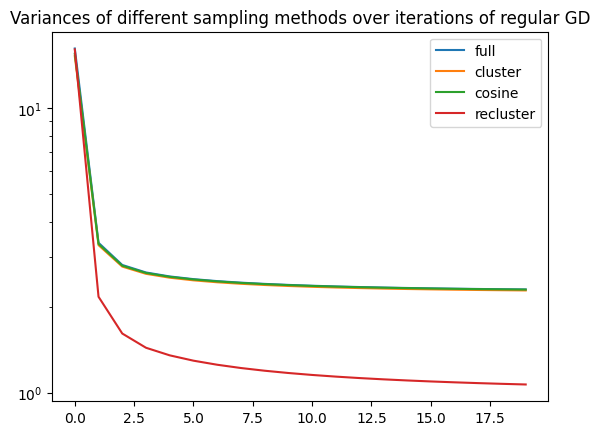

In [62]:
plot_labels = ["full", "cluster", "cosine", "recluster"]
for v, l in zip(variances, plot_labels):
    plt.plot(v, label=l)
plt.legend()
plt.yscale("log")
plt.title("Variances of different sampling methods over iterations of regular GD")
plt.show()

In [61]:
data, labels = cluster_dataloader.dataset.tensors
full_grad = np.mean(get_grad(data, labels, model), axis=0)

Is the variance the problem?

Note that if the variance is really negligible then convergence should look like regular gradient descent

In [51]:
def batch_sq_mean(batch, labels, model):
    batch_grads = get_grad(batch, labels, model)
    return np.mean(np.sum(batch_grads**2, axis=1))

In [ ]:
from torch.optim.lr_scheduler import LambdaLR

EXP_NB_EPOCH = 80
EXP_batch_size = 64

m_gd = SimpleModel(DIM, bias)
m_sgd = SimpleModel(DIM, bias)

optim_gd = torch.optim.SGD(m_gd.parameters(), lr=lr, weight_decay=l2)
schedul_gd = LambdaLR(optim_gd, lr_lambda=lr_lambda)

optim_sgd = torch.optim.SGD(m_sgd.parameters(), lr=lr, weight_decay=l2)
schedul_sgd = LambdaLR(optim_sgd, lr_lambda=lr_lambda)
loader = DataLoader(dataset, batch_size=EXP_batch_size, sampler=iid_sampler)

gd_losses = []
sgd_losses = []
var_over_time = []

for epoch in tqdm(range(EXP_NB_EPOCH)):
    for (batch, labels) in loader:
        # matching the number of iterations for full batch
        pred1 = m_gd(clustered_data)
        l1 = criterion(pred1, full_labels)
        optim_gd.zero_grad()
        l1.backward()
        optim_gd.step()
        # batches
        pred2 = m_sgd(batch)
        l2 = criterion(pred2, labels)
        optim_sgd.zero_grad()
        l2.backward()
        optim_sgd.step()
    variance = batch_variance(clustered_data, full_labels, m_sgd)/EXP_batch_size #batch_sq_mean(clustered_data, full_labels, m_sgd)
    
    schedul_gd.step()
    gd_losses.append(get_regularized_loss(m_gd, 
                                          clustered_data, 
                                          full_labels,
                                          criterion,
                                          l2).item())

    schedul_sgd.step()
    var_over_time.append(variance)
    sgd_losses.append(get_regularized_loss(m_sgd, 
                                           clustered_data, 
                                           full_labels,
                                           criterion,
                                           l2).item())


100%|██████████| 80/80 [04:12<00:00,  3.16s/it]


In [53]:
opt_val = min(opt_val, min(gd_losses))

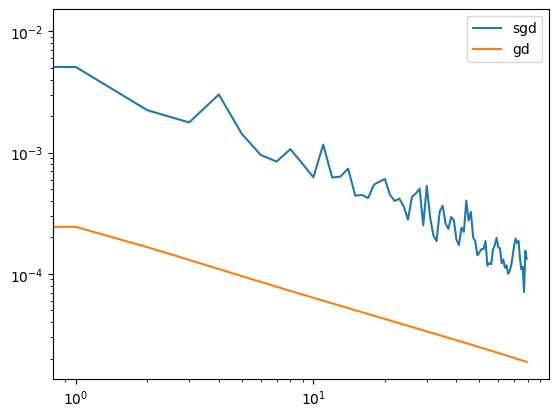

In [54]:
plt.plot(np.array(sgd_losses)-opt_val, label="sgd")
plt.plot(np.array(gd_losses)-opt_val, label="gd")
plt.legend()
plt.loglog()
plt.show()

In [55]:
model_norm = 0
for p in model.parameters():
    model_norm += (p.data**2).sum()
model_norm = model_norm.item()
model_norm

12.331050872802734

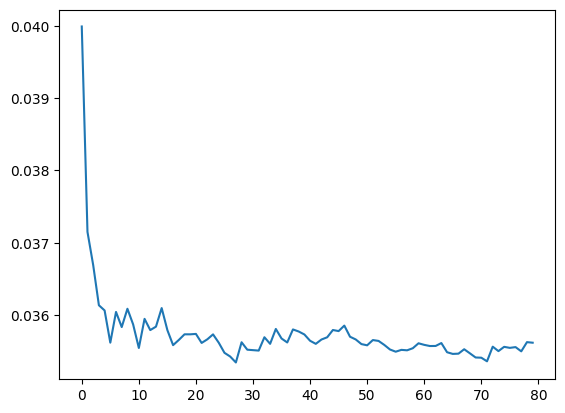

In [56]:
plt.plot(var_over_time)

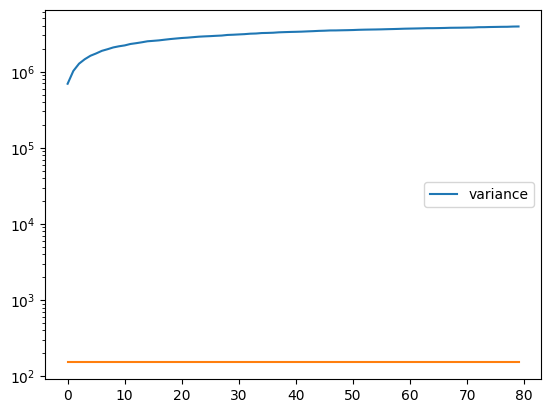

In [ ]:
linspace = np.arange(EXP_NB_EPOCH)

plt.plot(np.log(linspace+2)*var_over_time/(2*l2)**2, label="variance")
plt.plot([model_norm**2]*EXP_NB_EPOCH)
plt.yscale("log")
plt.legend()
plt.show()

For visualisation purposes when 2 dimensions

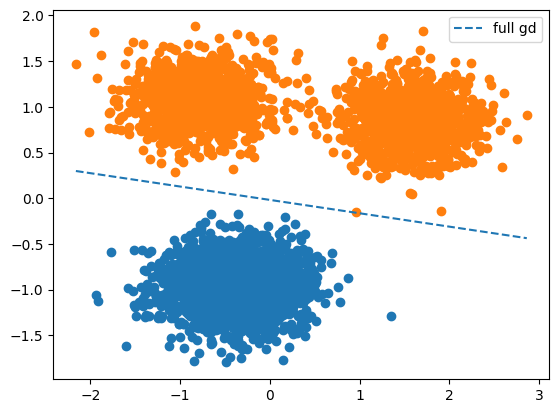

In [61]:
def plot_decision_boundary(data, model, label=None):
    w = model.layer.weight.detach().numpy().flatten()
    b = model.layer.bias.detach().item()
    x_vals = np.linspace(data[:,0].min(), data[:,0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + b) / w[1]
        plt.plot(x_vals, y_vals, '--', label=label)
    else:
        # vertical line if w[1] == 0
        x_const = -b / w[0]
        plt.axvline(x_const, linestyle='--', label=label)

plot_decision_boundary(clustered_data, model, "full gd")
# plot_decision_boundary(clustered_data, test_m, "test")

plt.scatter(clustered_data[mask_0, 0], clustered_data[mask_0, 1])
plt.scatter(clustered_data[mask_1, 0], clustered_data[mask_1, 1])
plt.legend()
plt.show()

Testing sampler speed to seek for improvement

In [ ]:
def test_sampler_speed(sampler):
    ITER_COUNT = 10
    dataloader = DataLoader(dataset, batch_size, sampler=sampler)
    begin = time.perf_counter()
    for i in range(ITER_COUNT):
        for (batch, labels) in dataloader:
            pass
    end = time.perf_counter()
    print((end - begin)/ITER_COUNT)

In [ ]:
test_sampler_speed(None)
test_sampler_speed(RandomSampler(dataset))
test_sampler_speed(ClusterSampler(dataset, batch_size, logistic_label_01_process))

0.1565863200000422
